# Rootfinding

In this notebook I will do the speed comparisons.

We want to find the roots of the following real functions $f_i : \mathbb{R} \to \mathbb{R}$.

- $f_1(x) = f_1(x) = 0.5 x^{-0.5} + 0.5 x^{-0.2}$
- $f_2(x) = \log(a+x) - b$ for $(a, b) = 1.5, 1$
- $f_3(x) = - U'(a_0 + y_0 - x) + \beta (1+r) U'((1+r)\cdot x + y_1) $
for $U'(c) = c^{-\sigma}$ and $(a_0, y_0, y_1, r, \beta, \sigma) = (1, 1, 1, 0.03, 0.99, 2)$.

- $ f_4(x) = - U'(y_0 + a_0 - x) + \beta (1+r) \frac{1}{2} \bigl( U'(y_L + (1+r) x) + U'(y_H + (1+r) x))\bigr) $
where $U'(c) = c^{-\sigma}$, $(a_0, y_0, \bar y, r, \beta, \sigma) = (1, 1, 1, 0.03, 0.99, 2)$ and $\lambda \in \{ 0, 0.25, 0.5, 0.75 \}$.

These functions are found in `testfunctions.jl` and in the module `testfunctions.f90`.

We are using the methods 
1. bisection
2. newton
3. brent (Fortran Code by [Tony Smith](www.econ.yale.edu/smith/)).

The corresponding functions can be found in the files `rootfinding.jl` and `rootfinding.f90`.

## Description of the program
```
for i = 1:1000
    f_2 > bisect, newton, brent
    f_3 > bisect, brent
    f_4(λ) > bisect, brent λ = 0.25
end
```



In [1]:
include("Julia/testfunctions.jl")
include("Julia/rootfinding.jl")

zbrent (generic function with 1 method)

The `Julia` version of the test program is provided below.

In [2]:
function test(dobrent::Bool; verbose=false)
    res2 = zeros(3)
    res3 = zeros(2)
    for i = 1:1000 
        x = 2.0
        xlow2 = 0.001
        xhigh2 = 5
        iterations = 40
        toler = 1e-10

        res2[1] = bisect(f2, xlow2, xhigh2, mxiter=iterations, toler=toler,verbose=verbose)
        res2[2] = newton(f2, f2p, xhigh2, mxiter=iterations, toler=toler, verbose=verbose)
        if dobrent
            res2[3] = zbrent(f2, xlow2, xhigh2, rtol=toler, ftol=toler, itmax=iterations, verbose=verbose)
        end
        
        xlow3, xhigh3 = 1e-5, 1.99
        res3[1] = bisect(f3, xlow3, xhigh3, mxiter=iterations, toler=toler, verbose=verbose)
        if dobrent
            res3[2] = zbrent(f3, xlow3, xhigh3, rtol=toler, ftol=toler, itmax=iterations, verbose=verbose)
        end
        #λ_vec = 0:0.25:0.75
        res4 = zeros(2)

        #for (i, λ) in enumerate(λ_vec)
#        if do4
            res4[1] = bisect(x::Real -> f4(x, 0.25), xlow3, xhigh3, mxiter=iterations, toler=toler, verbose=verbose)
            if dobrent 
                res4[2] = zbrent(x::Real -> f4(x, 0.25), xlow3, xhigh3, rtol=toler, ftol=toler, itmax=iterations, verbose=verbose)
            end
#        end
        #end
        if verbose
            mean2 = mean(res2)
            mean3 = mean(res3)
            mean4 = mean(res4)
            print("$mean2, $mean3, $mean4, $xlow2, $xhigh2\n")
        end
    end
end

# warm up
test(true)

I also provide the main program of the `Fortran` version (see also `test.f90`) for convenience.

```fortran
program main
  
  use constants
  use functions
  use rootfinding
 
  real(ndp) :: x = 2.0
  real(ndp) :: xlow2, xhigh2, xlow3, xhigh3, toler
  integer(i4b) :: i, iterations
  logical :: verbose = .false.
  
  real(ndp) :: res2(3), res3(2), res4(2)

  do i = 1,1000
     xlow2 = 0.001
     xhigh2 = 5
     iterations = 60
     toler = 1d-10

     res2(1) = bisect(f2, xlow2, xhigh2, iterations, toler, verbose)
     res2(2) = newton(f2, f2p, xhigh2, iterations, toler, verbose)
     res2(3) = zbrent(f2, xlow2, xhigh2, toler, toler, iterations, verbose)
     if (verbose) then
        write(6,"('f2: 'f15.8)") sum(res2)/3
     endif

     xlow3 = 0.1
     xhigh3 = 1.99
     res3(1) = bisect(f3, xlow3, xhigh3, iterations, toler, verbose)
     res3(2) = zbrent(f3, xlow3, xhigh3, toler, toler, iterations, verbose)
     if (verbose) then
        write(6,"('f3: 'f15.8)") sum(res3)/2
     endif

     res4(1) = bisect(f4, xlow3, xhigh3, iterations, toler, verbose)
     res4(2) = zbrent(f4, xlow3, xhigh3, toler, toler, iterations, verbose)
     if (verbose) then
        write(6,"('f4: 'f15.8)") sum(res4)/2
     endif
  enddo

  end program main
```

Call the `makefile` to compile the code.

In [3]:
; cd Fortran90

/Users/Fabian/Dropbox/Yale_Courses/Comp_Econ/Julia-for-Computational-Economics/Rootfinding/Fortran90


In [4]:
; make

gfortran -c constants.f90
gfortran -c testfunctions.f90
gfortran -c rootfinding.f90
gfortran -c test.f90
gfortran -o test.out test.o rootfinding.o testfunctions.o constants.o


In [5]:
; cd ..

/Users/Fabian/Dropbox/Yale_Courses/Comp_Econ/Julia-for-Computational-Economics/Rootfinding


In [6]:
N = 100
time_julia = zeros(N)
time_fortran = zeros(N)

for i = 1:N
    time_fortran[i] = @elapsed run(`./Fortran90/test.out`)
    time_julia[i] = @elapsed test(true)
end

In [7]:
using Plots, PyPlot

/Users/Fabian/.julia/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')



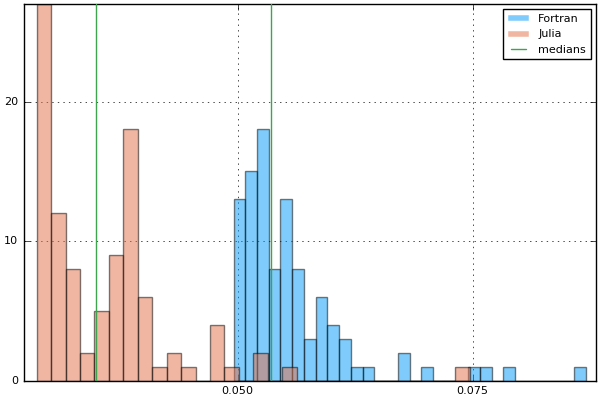

In [8]:
pyplot()

histogram(time_fortran, label="Fortran", alpha=0.5)
histogram!(time_julia, label="Julia", alpha=0.5)

plot!([median(time_fortran);median(time_julia)], linetype=:vline, label="medians")
#hline!(median(time_fortran))
#hline!(median(time_julia))